In [1]:
import os
import pandas as pd

In [4]:
# !pip list

In [2]:
df = pd.read_csv('../results/cut_segments_pulp_fiction.csv')
df.head()

,Unnamed: 0,speaker,id,duration,text,seg,start,end,start_tt,end_tt,input_path
0,0,Pumpkin,1,4,Forget it . It 's too risky . I 'm through doi...,"00:00:26,950 --> 00:00:30,878","00:00:26,950","00:00:30,878",26.950,30.878,cut_preprocessed/audio_track_pulp_fiction_eng_...
1,1,Honey Bunny,2,3,You always say that . The same thing every time .,"00:00:30,946 --> 00:00:34,263","00:00:30,946","00:00:34,263",30.946,34.263,cut_preprocessed/audio_track_pulp_fiction_eng_...
2,2,Honey Bunny,3,2,"`` I 'm through , never again , too dangerous ...","00:00:34,260 --> 00:00:36,254","00:00:34,260","00:00:36,254",34.260,36.254,cut_preprocessed/audio_track_pulp_fiction_eng_...
3,3,Pumpkin,4,2,I know that 's what I always say . I 'm always...,"00:00:36,253 --> 00:00:38,716","00:00:36,253","00:00:38,716",36.253,38.716,cut_preprocessed/audio_track_pulp_fiction_eng_...
4,4,Honey Bunny,5,3,You forget about it in a day or two .,"00:00:38,715 --> 00:00:42,043","00:00:38,715","00:00:42,043",38.715,42.043,cut_preprocessed/audio_track_pulp_fiction_eng_...


In [58]:
import logging
from vanpy.utils.utils import load_config

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s:%(name)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

config = load_config('configs/pulp_fiction_pipeline.yaml')

In [3]:
from vanpy.core.Pipeline import Pipeline
pipeline = Pipeline(
        # ['silero_vad',
         ['file_mapper', 'librosa_features_extractor', 'speechbrain_embedding', 'openai_whisper_stt', 'speech_brain_iemocap_emotion',
         'vanpy_gender', 'vanpy_age', 'vanpy_height', 'vanpy_emotion', 'wav2vec2adv', 'yamnet_classifier', 'cosine_distance_diarization', 'agglomerative_clustering_diarization', 'gmm_clustering_diarization'], config=config)

2023-07-09 16:44:24 - INFO:PreprocessPipeline - Created Preprocessing Pipeline with 2 components


In [ ]:
from vanpy.core.ComponentPayload import ComponentPayload
df['input_path'] = df['input_path'].apply(lambda x: "../" + x)
metadata = {'input_path': '', 'paths_column': 'input_path', 'all_paths_columns': ['input_path'],
                             'meta_columns': [], 'feature_columns': [], 'classification_columns': []}
cp = ComponentPayload(df=df, metadata=metadata)
processed_payload = pipeline.process(initial_payload=cp)

In [4]:
processed_payload = pipeline.process()

2023-07-09 16:44:26 - INFO:PreprocessPipeline - Processing with file_mapper
2023-07-09 16:44:26 - INFO:preprocessing - file_mapper - Called Saved payload ('file_mapper', False), intermediate False
2023-07-09 16:44:26 - INFO:PreprocessPipeline - Processing with sepformer_se
2023-07-09 16:44:27 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2023-07-09 16:44:28 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2023-07-09 16:44:28 - INFO:speechbrain.pretrained.fetching - Fetch hyperparams.yaml: Using existing file/symlink in pretrained_models\sepformer-wham16k-enhancement\hyperparams.yaml.
2023-07-09 16:44:28 - INFO:speechbrain.pretrained.fetching - Fetch custom.py: Delegating to Huggingface hub, source speechbrain/sepformer-wham16k-enhancement.
2023-07-09 16:44:28 - WARNING:speechbrain.utils

In [80]:
features_and_annotations_df = pd.merge(left=processed_payload.get_classification_df().dropna(), right=processed_payload.df[['silero_vad_processed_path', 'speaker', 'id', 'duration', 'text', 'start_tt', 'end_tt']].dropna(), on='silero_vad_processed_path', how='inner')

In [81]:
from collections import Counter

ids_counter = Counter(features_and_annotations_df['id'])  # remove more than one speaker in a segment
ids_to_remove = [k for k, v in ids_counter.items() if v > 1]
features_and_annotations_df = features_and_annotations_df[~features_and_annotations_df['id'].isin(ids_to_remove)]

In [7]:
# features_and_annotations_df.to_csv('results/pulp_fiction/classification_pulp_fiction.csv')
features_and_annotations_df = pd.read_csv('results/pulp_fiction/classification_pulp_fiction.csv')
features_and_annotations_df = features_and_annotations_df[~features_and_annotations_df['text'].str.startswith('-LSB-')]
features_and_annotations_df = features_and_annotations_df[features_and_annotations_df['end_tt'] - features_and_annotations_df['start_tt'] > 1]

In [4]:
film_final_shooting_date = '30.11.1993'
actors_df = pd.read_csv('data/Pulp_Fiction_Actors.tsv', sep='\t')
actors_df['screening_age'] = actors_df['birth_date'].apply(lambda x: (pd.to_datetime(film_final_shooting_date) - pd.to_datetime(x)).days / 365)

In [8]:
actors_df

,actor,character,gender,birth_date,height,screening_age
0,Tim Roth,Pumpkin,M,14.05.1961,1.73,32.569863
1,Amanda Plummer,Honey Bunny,F,23.03.1957,1.63,36.715068
2,John Travolta,Vincent Vega,M,14.02.1954,1.88,39.819178
3,Samuel L. Jackson,Jules Winnfield,M,21.12.1948,1.89,44.972603
4,Phil LaMarr,Marvin,M,24.01.1967,1.77,26.868493
5,Frank Whaley,Brett,M,20.07.1963,1.75,30.386301
6,Burr Steers,Roger,M,08.10.1965,NaN,28.326027
7,Bruce Willis,Butch Coolidge,M,19.03.1955,1.82,38.728767
8,Ving Rhames,Marsellus Wallace,M,12.05.1959,1.80,34.010959
9,Paul Calderon,Paul,M,07.07.1959,NaN,34.424658


In [9]:
features_and_annotations_df

,Unnamed: 0,silero_vad_processed_path,whisper_transcript,whisper_language,speech_brain_iemocap_emotion,vanpy_voxceleb_gender_classification,vanpy_voxceleb_age_estimation,vanpy_voxceleb_height_estimation,vanpy_ravdess_emotion,arousal,dominance,valence,yamnet_classification,diarization_classification,speaker,id,duration,text,start_tt,end_tt
0,0,silero_vad_preprocessed/audio_track_pulp_ficti...,to get it. It's too risky.,en,neu,male,30.882626,181.85678,fearful,0.568810,0.589491,0.381561,Speech,SPEAKER_0,Pumpkin,1,4,Forget it . It 's too risky . I 'm through doi...,26.950,30.878
1,1,silero_vad_preprocessed/audio_track_pulp_ficti...,You'll say that the same thing every time. I'...,en,sad,female,49.481808,158.77185,surprised,0.543270,0.575906,0.491519,Speech,SPEAKER_1,Honey Bunny,2,3,You always say that . The same thing every time .,30.946,34.263
2,2,silero_vad_preprocessed/audio_track_pulp_ficti...,never again too dangerous.,en,neu,female,37.741985,167.69025,surprised,0.360790,0.448852,0.353106,Speech,SPEAKER_1,Honey Bunny,3,2,"`` I 'm through , never again , too dangerous ...",34.260,36.254
3,3,silero_vad_preprocessed/audio_track_pulp_ficti...,And that's why I always say I'm always right ...,en,neu,male,29.821240,177.66922,neutral/calm,0.536591,0.576020,0.654322,Speech,SPEAKER_2,Pumpkin,4,2,I know that 's what I always say . I 'm always...,36.253,38.716
4,6,silero_vad_preprocessed/audio_track_pulp_ficti...,Copyright 2004.,en,sad,male,33.517670,178.54314,fearful,0.506780,0.544164,0.662310,Speech,SPEAKER_2,Pumpkin,6,2,The days of me remembering have just begun .,42.040,44.119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,2010,silero_vad_preprocessed/audio_track_pulp_ficti...,week.,en,ang,male,46.128830,186.65475,sad,0.311069,0.447930,0.343298,Speech,SPEAKER_43,Jules Winnfield,2184,1,you 're the weak ...,8530.376,8532.230
1232,2011,silero_vad_preprocessed/audio_track_pulp_ficti...,Ageness legacies at будтоcal Rio de Godan Eve...,en,neu,male,43.806385,190.85503,sad,0.287299,0.426815,0.514851,Speech,SPEAKER_40,Jules Winnfield,2185,3,and I 'm the tyranny of evil men .,8533.574,8536.835
1233,2012,silero_vad_preprocessed/audio_track_pulp_ficti...,Easter In prevent pie hi,en,neu,male,52.639133,199.86975,sad,0.096224,0.255936,0.306560,Speech,SPEAKER_2,Jules Winnfield,2186,1,"But I 'm tryin ' , Ringo .",8538.178,8540.033
1234,2013,silero_vad_preprocessed/audio_track_pulp_ficti...,real.,en,neu,male,61.613770,188.54291,neutral/calm,0.392980,0.472016,0.547569,Speech,SPEAKER_1,Jules Winnfield,2187,2,I 'm tryin ' real hard ...,8541.247,8544.062


In [ ]:
# features_and_annotations_df.to_csv('results/pulp_fiction/classification_pulp_fiction.csv')

In [30]:
# features_and_annotations_df[features_and_annotations_df.isna().any(axis=1)]

In [10]:
features_df = pd.read_csv('results/pulp_fiction/final_feature_classification_df.csv')
features_df = features_df[features_df['id'].isin(features_and_annotations_df['id'])]

In [6]:
# features_df.to_csv('results/pulp_fiction/final_feature_classification_1190_df.csv')

In [5]:
from vanpy.utils.utils import load_config
from vanpy.core.Pipeline import Pipeline
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s:%(name)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')


config = load_config('configs/pulp_fiction_pipeline.yaml')
pipeline = Pipeline(
        ['file_mapper', 'agglomerative_clustering_diarization'] , config=config)
diarization_payload = pipeline.process()
diarization_df = diarization_payload.df

2023-07-10 16:59:18 - INFO:PreprocessPipeline - Created Preprocessing Pipeline with 1 components
2023-07-10 16:59:19 - INFO:ClassificationPipeline - Created Classification Pipeline with 1 components
2023-07-10 16:59:19 - INFO:PreprocessPipeline - Processing with file_mapper
2023-07-10 16:59:19 - INFO:preprocessing - file_mapper - Called Saved payload ('file_mapper', False), intermediate False
2023-07-10 16:59:19 - INFO:ClassificationPipeline - Processing with agglomerative_clustering_diarization
2023-07-10 16:59:19 - INFO:segment_classifier - agglomerative_clustering_diarization - Called Saved payload ('agglomerative_clustering_diarization', True), intermediate False
2023-07-10 16:59:19 - INFO:segment_classifier - agglomerative_clustering_diarization - Saved payload in results/pulp_fiction


In [67]:
# leave only top10 'speaker's by row counts
diarization_df = diarization_df[diarization_df['speaker'].isin(diarization_df['speaker'].value_counts().head(10).index)]

In [70]:
len(diarization_df)

1030

In [6]:
# diarization_df.columns

Index(['Unnamed: 0', '0_speechbrain_embedding', '1_speechbrain_embedding',
       '2_speechbrain_embedding', '3_speechbrain_embedding',
       '4_speechbrain_embedding', '5_speechbrain_embedding',
       '6_speechbrain_embedding', '7_speechbrain_embedding',
       '8_speechbrain_embedding',
       ...
       'vanpy_voxceleb_height_estimation', 'vanpy_ravdess_emotion', 'arousal',
       'dominance', 'valence', 'perf_wav2vec2adv_get_transcription',
       'yamnet_classification', 'diarization_classification',
       'perf_cosine_distance_diarization_get_diarization',
       'perf_agglomerative_clustering_diarization_get_diarization'],
      dtype='object', length=224)

In [54]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.preprocessing import normalize
#
# # obtain embeddings as a 2D numpy array
# embeddings = diarization_df[[f'{i}_speechbrain_embedding' for i in range(192)]].values
#
# # normalize all embeddings
# embeddings_normalized = normalize(embeddings, axis=1, norm='l2')
#
# # perform hierarchical clustering
# clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=2.3).fit(embeddings_normalized)
#
# # assign labels to the original DataFrame
# diarization_df['cluster_label'] = clustering.labels_

# print(diarization_df['cluster_label'])


In [71]:
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

embeddings = diarization_df[[f'{i}_speechbrain_embedding' for i in range(192)]].values

# normalize all embeddings
embeddings_normalized = normalize(embeddings, axis=1, norm='l2')

# Scale your data to normalize it. DBSCAN is sensitive to the scale because it relies on the concept of distance.
embeddings = StandardScaler().fit_transform(embeddings_normalized)

# Perform DBSCAN on the data.
# The eps parameter is the maximum distance between two samples for one to be considered as in the neighborhood of the other.
# This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
db = DBSCAN(eps=15, min_samples=3).fit(embeddings)

# add labels to the original DataFrame
diarization_df['diarization_classification'] = db.labels_

print(diarization_df['diarization_classification'])

0      -1
3       0
4       0
6       0
7      -1
       ..
1185   -1
1186    2
1187   -1
1188   -1
1189   -1
Name: diarization_classification, Length: 1030, dtype: int64


C:\Users\check\AppData\Local\Temp\ipykernel_32376\4072416596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diarization_df['diarization_classification'] = db.labels_


In [82]:
from sklearn.mixture import GaussianMixture

# Create a GMM model
gmm = GaussianMixture(n_components=30)

# Fit the GMM model
gmm.fit(embeddings)

# Predict the labels for the data points
labels = gmm.predict(embeddings)

# Add the labels to your DataFrame
diarization_df['diarization_classification'] = labels
# labels

C:\Users\check\AppData\Local\Temp\ipykernel_32376\1348692231.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diarization_df['diarization_classification'] = labels


In [83]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# First, we'll reduce the dimension of the embeddings to 2 dimensions using PCA
pca = PCA(n_components=5)
embeddings_pca = pca.fit_transform(embeddings)

# Then we can apply the KMeans clustering (or any other clustering method) to the reduced data
kmeans = KMeans(n_clusters=30)
labels = kmeans.fit_predict(embeddings_pca)

# Add the labels to your DataFrame
diarization_df['diarization_classification'] = labels

C:\Users\check\AppData\Local\Temp\ipykernel_32376\3833351627.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diarization_df['diarization_classification'] = labels


In [84]:
diarization_df['diarization_classification'].value_counts()

8     56
24    47
3     44
5     43
6     43
9     43
21    42
7     42
20    41
29    40
2     39
19    38
22    38
15    35
26    35
14    35
11    34
4     33
0     33
10    33
13    31
28    31
25    27
23    26
18    25
27    23
17    21
12    20
1     18
16    14
Name: diarization_classification, dtype: int64

In [85]:
# diarization_df[['diarization_classification', 'speaker']]
diarization_df[['diarization_classification', 'speaker']]

,diarization_classification,speaker
0,15,Pumpkin
3,7,Pumpkin
4,7,Pumpkin
6,10,Pumpkin
7,15,Pumpkin
...,...,...
1185,26,Jules Winnfield
1186,3,Jules Winnfield
1187,27,Jules Winnfield
1188,24,Jules Winnfield


In [86]:
counts_df = diarization_df.groupby(['speaker', 'diarization_classification']).size().reset_index(name='counts')
counts_df

,speaker,diarization_classification,counts
0,Butch Coolidge,1,5
1,Butch Coolidge,2,5
2,Butch Coolidge,3,3
3,Butch Coolidge,5,24
4,Butch Coolidge,6,38
...,...,...,...
105,Winston Wolf,17,21
106,Winston Wolf,18,1
107,Winston Wolf,22,1
108,Winston Wolf,24,1


In [87]:
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# # Pivot your data
# heatmap_data = counts_df.pivot('speaker', 'diarization_classification', 'counts')
#
# # Create the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f")
# plt.title('Heatmap of Speaker Assignments')
# plt.show()

In [90]:
len(counts_df['diarization_classification'].unique())

30

In [95]:
matrix

,1,2,3,5,6,9,10,15,16,18,...,26,28,0,12,29,4,11,20,14,17
Butch Coolidge,5.0,5.0,3.0,24.0,38.0,7.0,2.0,4.0,4.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Captain Koons,0.0,4.0,1.0,3.0,2.0,31.0,2.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fabienne,0.0,14.0,0.0,1.0,0.0,2.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jules Winnfield,4.0,4.0,40.0,0.0,0.0,1.0,6.0,11.0,0.0,3.0,...,34.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lance,1.0,1.0,0.0,8.0,2.0,1.0,3.0,4.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Marsellus Wallace,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,28.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
Mia Wallace,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,31.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0
Pumpkin,0.0,5.0,0.0,3.0,0.0,1.0,10.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vincent Vega,1.0,0.0,0.0,3.0,1.0,0.0,6.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,32.0,34.0,41.0,0.0,0.0
Winston Wolf,7.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,10.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35.0,21.0


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import linear_sum_assignment

# First, we create a square matrix with 'SPEAKER_X' and 'speaker' counts
speakers = counts_df['speaker'].unique()
speaker_x = counts_df['diarization_classification'].unique()

matrix = pd.DataFrame(
    np.zeros((len(speakers), len(speaker_x))),
    index=speakers, columns=speaker_x
)

for _, row in counts_df.iterrows():
    matrix.loc[row['speaker'], row['diarization_classification']] = row['counts']

# We use the linear_sum_assignment function from scipy to solve
# the assignment problem (also known as the Hungarian algorithm)
# Note: as it's a minimization algorithm, we multiply by -1 to get maximization
row_ind, col_ind = linear_sum_assignment(-matrix.values)

# These indices are sorted in the way that maximizes the assignment,
# let's use them to sort the original DataFrame
sorted_speakers = matrix.index[row_ind]
sorted_speaker_x = matrix.columns[col_ind]

# Finally, we reorder the rows and columns according to this sorting
ordered_matrix = matrix.loc[sorted_speakers, sorted_speaker_x]

# Now you can create your heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_matrix, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title('Heatmap of Speaker Assignments')
plt.show()

ValueError: cannot reshape array of size 330 into shape (10,30)

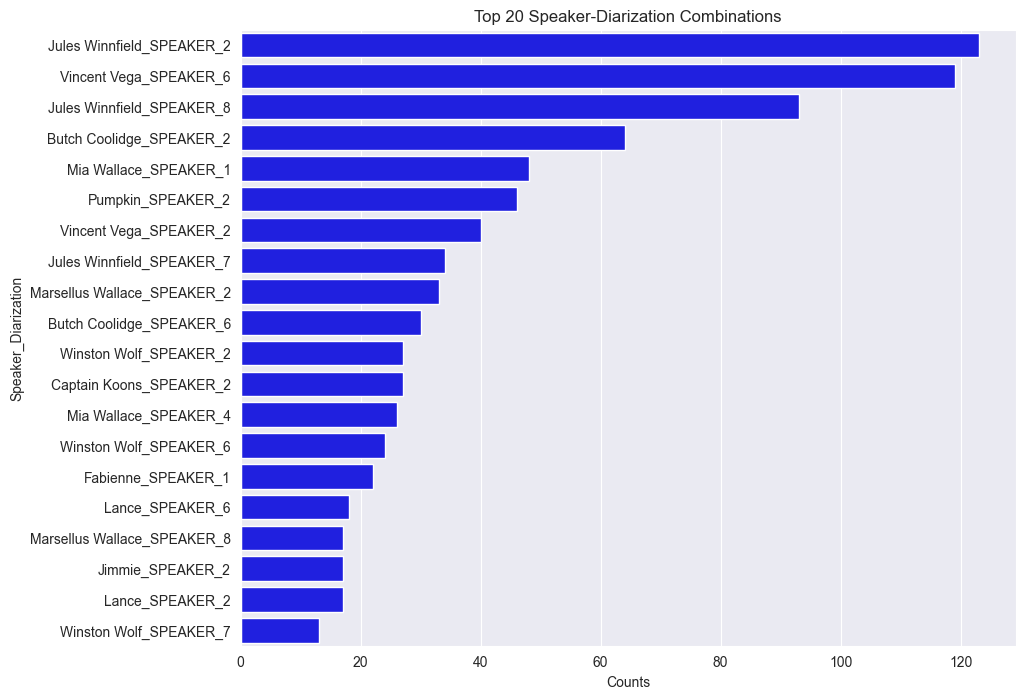

In [10]:
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# # create a new column that combines the speaker and diarization_classification for labeling purpose
# counts_df['speaker_diarization'] = counts_df['speaker'] + '_' + counts_df['diarization_classification']
#
# # Sort DataFrame based on counts
# counts_df = counts_df.sort_values('counts', ascending=False)
#
# # Take the top N rows for visualization
# N = 20  # or whatever number you prefer
# top_counts_df = counts_df.head(N)
#
# # Plot
# plt.figure(figsize=(10, 8))
# sns.barplot(x='counts', y='speaker_diarization', data=top_counts_df, color='b')
# plt.xlabel('Counts')
# plt.ylabel('Speaker_Diarization')
# plt.title(f'Top {N} Speaker-Diarization Combinations')
# plt.show()

In [74]:
# threshold 0.5 - 992, 0.3 - 190, 0.2 - 7, 0.25 - 44, 0.23 - 16
diarization_df['diarization_classification'].unique()

array(['SPEAKER_0', 'SPEAKER_1', 'SPEAKER_2', 'SPEAKER_3', 'SPEAKER_4',
       'SPEAKER_5', 'SPEAKER_6', 'SPEAKER_7', 'SPEAKER_8', 'SPEAKER_9',
       'SPEAKER_10', 'SPEAKER_11', 'SPEAKER_12', 'SPEAKER_13',
       'SPEAKER_14', 'SPEAKER_15', 'SPEAKER_16', 'SPEAKER_17',
       'SPEAKER_18', 'SPEAKER_19', 'SPEAKER_20', 'SPEAKER_21',
       'SPEAKER_22', 'SPEAKER_23', 'SPEAKER_24', 'SPEAKER_25',
       'SPEAKER_26', 'SPEAKER_27'], dtype=object)

In [75]:
diarization_df['speaker'].unique()

array(['Pumpkin', 'Honey Bunny', 'Unknown', 'Vincent Vega',
       'Jules Winnfield', 'Brett', 'Roger', 'Marsellus Wallace',
       'Butch Coolidge', 'Paul', 'Trudi', 'Jody', 'Lance', 'Mia Wallace',
       'Ed Sullivan', 'Buddy Holly', "Butch's Mother", 'Captain Koons',
       'Floyd Wilson', 'Esmarelda Villalobos', 'Fabienne', 'Maynard',
       'Zed', 'Marvin', 'Jimmie', 'Winston Wolf', 'Raquel'], dtype=object)

C:\ProgramData\miniconda3\envs\vanpy-gpu-3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\miniconda3\envs\vanpy-gpu-3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


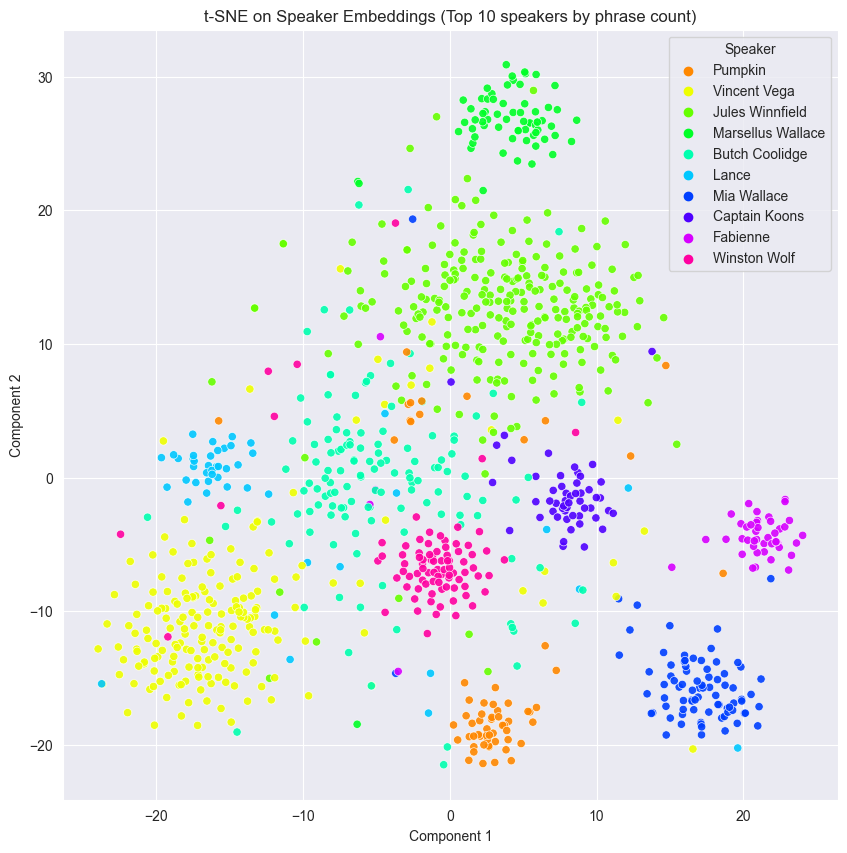

In [11]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Select the necessary columns
feature_cols = [str(i) + '_speechbrain_embedding' for i in range(192)]
features = features_df[feature_cols].dropna()

# Get the top 10 speakers by phrase count
top_speakers = features_df['speaker'].value_counts().nlargest(10).index

# Filter the features and speaker data to include only the top speakers
features_top_speakers = features[features_df['speaker'].isin(top_speakers)]
speakers_top_speakers = features_df[features_df['speaker'].isin(top_speakers)]['speaker']

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the features of the top speakers
tsne_results = tsne.fit_transform(features_top_speakers)

# Create a DataFrame to plot
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Component 1', 'Component 2'])
tsne_df['Speaker'] = speakers_top_speakers.reset_index(drop=True)

# Use seaborn to visualize the result
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="Speaker",
    palette=sns.color_palette("hsv", len(tsne_df['Speaker'].unique())),
    data=tsne_df,
    legend="full",
    alpha=0.9
)

plt.title('t-SNE on Speaker Embeddings (Top 10 speakers by phrase count)')
plt.show()

In [11]:
features_and_annotations_df['gender_value'] = features_and_annotations_df['vanpy_voxceleb_gender_classification'].apply(lambda x: 1 if x == 'male' else 0)

In [12]:
mean_estimation_df = features_and_annotations_df[['speaker', 'gender_value', 'vanpy_voxceleb_age_estimation', 'vanpy_voxceleb_height_estimation', 'arousal', 'dominance', 'valence']].groupby('speaker').mean()

In [13]:
mean_estimation_df

,gender_value,vanpy_voxceleb_age_estimation,vanpy_voxceleb_height_estimation,arousal,dominance,valence
speaker,,,,,,
Brett,1.000000,37.986972,177.468991,0.542076,0.568118,0.469214
Buddy Holly,0.750000,39.126655,182.285560,0.511001,0.530898,0.583042
Butch Coolidge,0.977099,47.402189,183.628694,0.530984,0.544476,0.452060
Butch's Mother,0.000000,44.103842,171.003410,0.481765,0.543033,0.545290
Captain Koons,1.000000,50.586125,184.762862,0.407695,0.486726,0.457898
Ed Sullivan,0.888889,55.542465,187.829537,0.677836,0.654026,0.507951
Esmarelda Villalobos,0.062500,45.323785,182.951362,0.433721,0.437948,0.456534
Fabienne,0.063830,43.751620,171.757504,0.423398,0.463539,0.471451
Floyd Wilson,1.000000,54.058636,171.169820,0.618965,0.527662,0.538359


In [14]:
pd.merge(left=actors_df, right=mean_estimation_df, left_on='character', right_on='speaker', how='inner')

,actor,character,gender,birth_date,height,screening_age,gender_value,vanpy_voxceleb_age_estimation,vanpy_voxceleb_height_estimation,arousal,dominance,valence
0,Tim Roth,Pumpkin,M,14.05.1961,1.73,32.569863,0.936508,39.531269,182.627153,0.605659,0.615189,0.412473
1,Amanda Plummer,Honey Bunny,F,23.03.1957,1.63,36.715068,0.230769,49.238243,174.876326,0.652721,0.648586,0.392672
2,John Travolta,Vincent Vega,M,14.02.1954,1.88,39.819178,0.968254,46.382999,183.373992,0.462415,0.500180,0.396287
3,Samuel L. Jackson,Jules Winnfield,M,21.12.1948,1.89,44.972603,0.992453,46.873100,187.033322,0.577717,0.621077,0.422042
4,Phil LaMarr,Marvin,M,24.01.1967,1.77,26.868493,1.000000,74.016480,187.134060,0.423724,0.487634,0.325739
5,Frank Whaley,Brett,M,20.07.1963,1.75,30.386301,1.000000,37.986972,177.468991,0.542076,0.568118,0.469214
6,Burr Steers,Roger,M,08.10.1965,NaN,28.326027,1.000000,45.425647,188.487720,0.344442,0.419099,0.468964
7,Bruce Willis,Butch Coolidge,M,19.03.1955,1.82,38.728767,0.977099,47.402189,183.628694,0.530984,0.544476,0.452060
8,Ving Rhames,Marsellus Wallace,M,12.05.1959,1.80,34.010959,1.000000,44.690409,192.748922,0.440912,0.519432,0.362192
9,Paul Calderon,Paul,M,07.07.1959,NaN,34.424658,1.000000,44.363082,184.968624,0.596699,0.624593,0.607669


In [15]:
merged_df = pd.merge(left=actors_df, right=mean_estimation_df, left_on='character', right_on='speaker', how='inner')
merged_df['height'] = merged_df['height'].apply(lambda x: x * 100)
merged_df['gender_confidence'] = merged_df.apply(lambda x: x['gender_value'] if x['gender'] == "M" else 1 - x['gender_value'], axis=1)

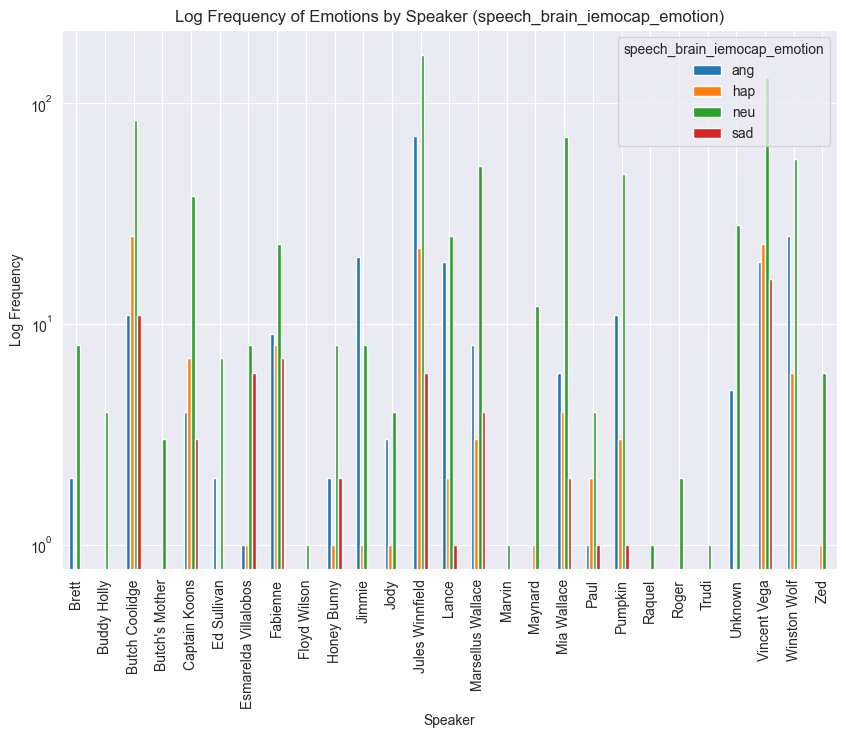

In [16]:
from matplotlib import pyplot as plt

# Create a cross-tabulation of 'speaker' and 'vanpy_ravdess_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Plot the grouped bar chart
emotion_by_speaker.plot(kind='bar', stacked=False, figsize=(10, 7))

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Log Frequency')
plt.title('Log Frequency of Emotions by Speaker (speech_brain_iemocap_emotion)')

# Set y-axis to log scale
plt.yscale('log')

plt.show()

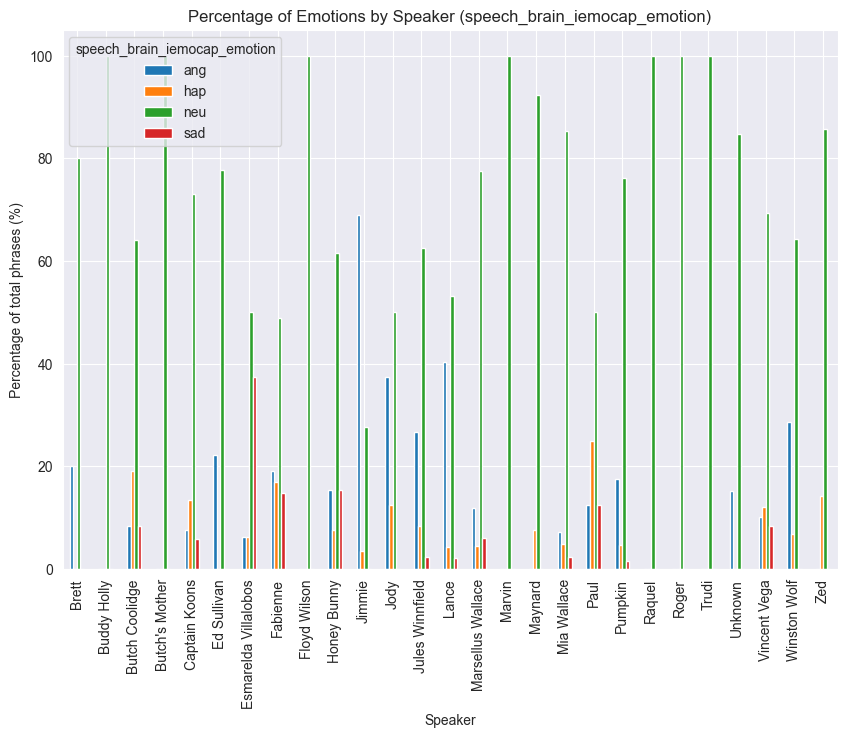

In [17]:
import numpy as np

# Create a cross-tabulation of 'speaker' and 'vanpy_ravdess_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Normalize each row (speaker) to sum to 1 (proportion of total phrases)
emotion_by_speaker = emotion_by_speaker.div(emotion_by_speaker.sum(axis=1), axis=0)

# Convert to percentages
emotion_by_speaker = emotion_by_speaker.mul(100)

# Plot the grouped bar chart
emotion_by_speaker.plot(kind='bar', stacked=False, figsize=(10, 7))

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Percentage of total phrases (%)')
plt.title('Percentage of Emotions by Speaker (speech_brain_iemocap_emotion)')

plt.show()

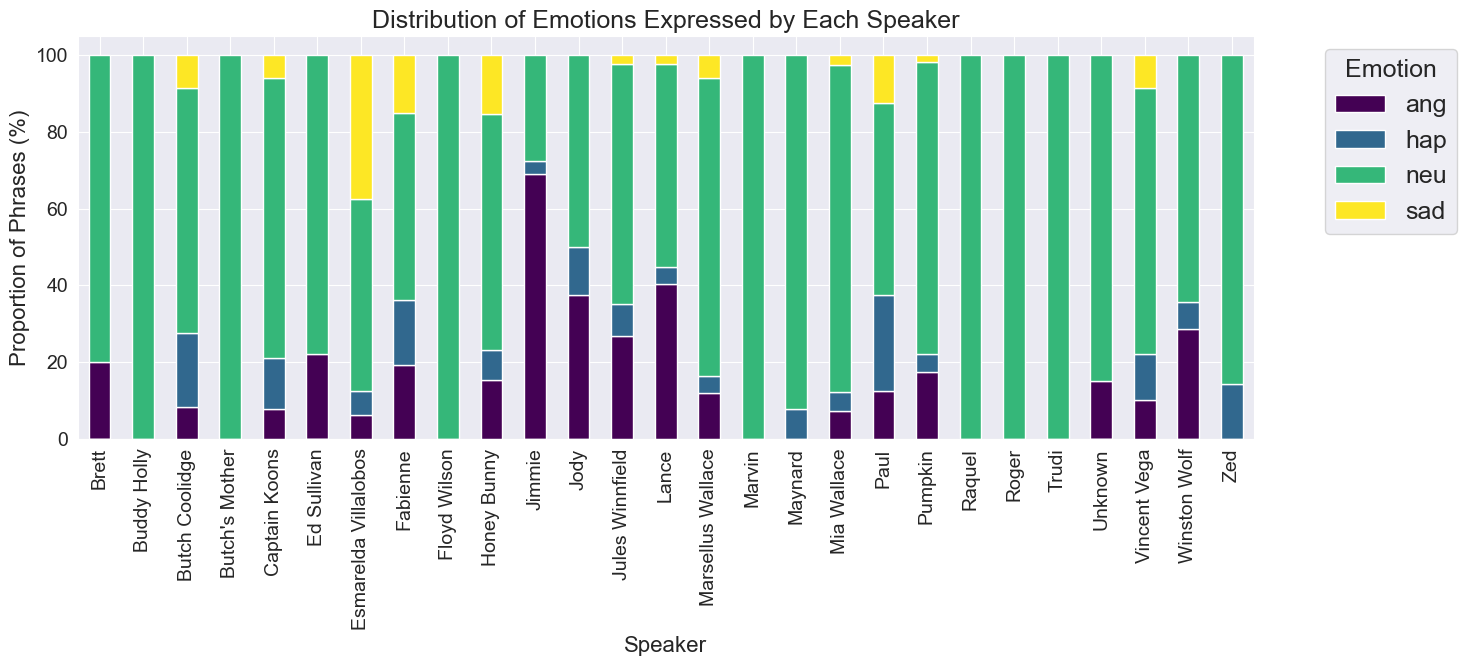

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18, 'axes.titlesize': 18, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 18})

# Create a cross-tabulation of 'speaker' and 'speech_brain_iemocap_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Normalize each row (speaker) to sum to 1 (proportion of total phrases)
emotion_by_speaker = emotion_by_speaker.div(emotion_by_speaker.sum(axis=1), axis=0)

# Convert to percentages
emotion_by_speaker = emotion_by_speaker.mul(100)

# Plot the stacked bar chart
ax = emotion_by_speaker.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='viridis')

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Proportion of Phrases (%)')
plt.title('Distribution of Emotions Expressed by Each Speaker')

# Add legend and adjust its location
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

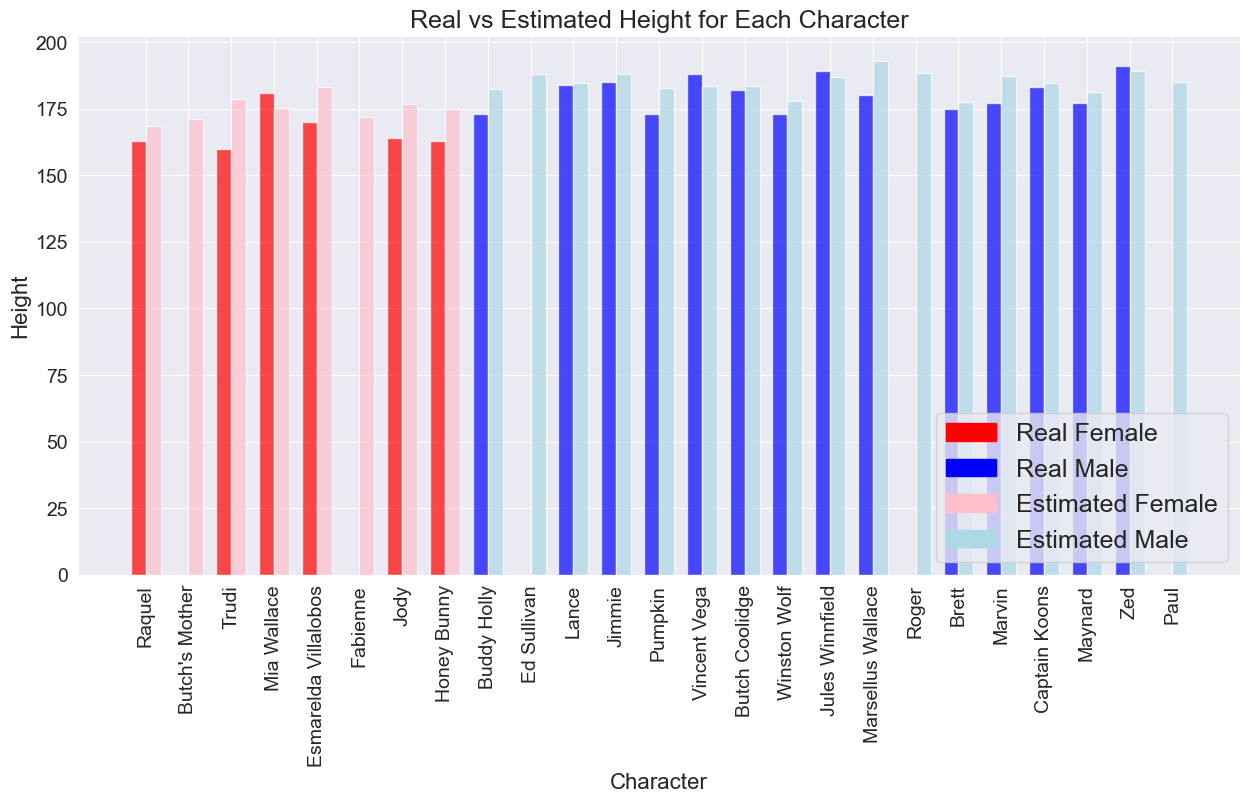

In [30]:
# plot real height distribution vs vanpy height estimation distribution grouped by gender
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18, 'axes.titlesize': 18, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 18})

# Sort by gender_value
sorted_df = merged_df.sort_values('gender_value')

# Set colors based on gender
colors = ['red' if g == 'F' else 'blue' for g in sorted_df['gender']]
light_colors = ['pink' if g == 'F' else 'lightblue' for g in sorted_df['gender']]  # light red and light blue

# Create an index for each character
ind = np.arange(len(sorted_df))

# Create the bar plot
plt.figure(figsize=(15, 7))  # Adjust size as needed
width = 0.35  # width of the bars

# Plot the real heights
plt.bar(ind - width/2, sorted_df['height'], width, color=colors, alpha=0.7, label='Real')

# Plot the estimated heights
plt.bar(ind + width/2, sorted_df['vanpy_voxceleb_height_estimation'], width, color=light_colors, alpha=0.7, label='Estimated')

# Label axes and title
plt.xlabel('Character')
plt.ylabel('Height')
plt.title('Real vs Estimated Height for Each Character')

# Rotate x labels if needed and set them to character names
plt.xticks(ind, sorted_df['character'], rotation=90)

# Create legend
red_patch = mpatches.Patch(color='red', label='Real Female')
blue_patch = mpatches.Patch(color='blue', label='Real Male')
light_red_patch = mpatches.Patch(color='pink', label='Estimated Female')
light_blue_patch = mpatches.Patch(color='lightblue', label='Estimated Male')

plt.legend(handles=[red_patch, blue_patch, light_red_patch, light_blue_patch], loc='lower right')

# Show the plot
plt.show()

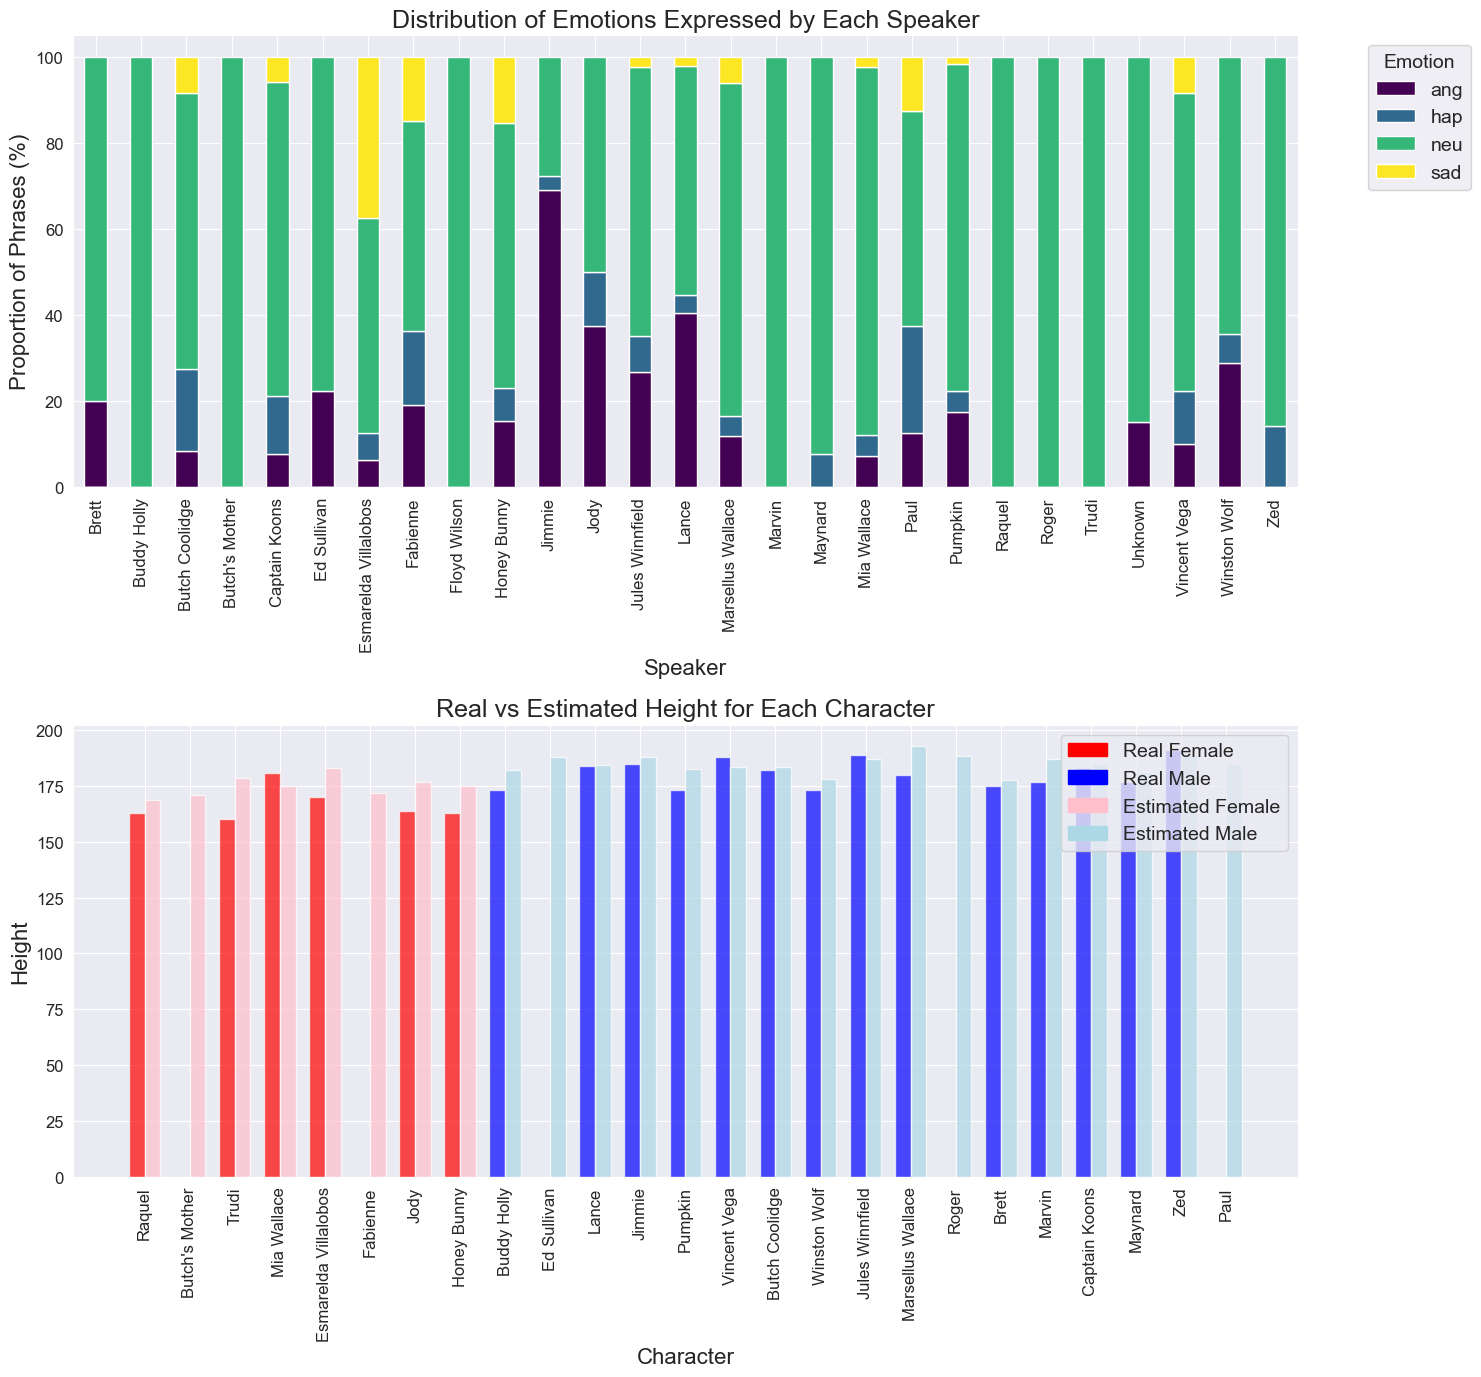

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Adjust font sizes
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 14})

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))

# First plot: Distribution of Emotions Expressed by Each Speaker
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])
emotion_by_speaker = emotion_by_speaker.div(emotion_by_speaker.sum(axis=1), axis=0).mul(100)
emotion_by_speaker.plot(kind='bar', stacked=True, colormap='viridis', ax=ax1)

ax1.set_xlabel('Speaker')
ax1.set_ylabel('Proportion of Phrases (%)')
ax1.set_title('Distribution of Emotions Expressed by Each Speaker')
ax1.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')

# Second plot: Real vs Estimated Height for Each Character
sorted_df = merged_df.sort_values('gender_value')
colors = ['red' if g == 'F' else 'blue' for g in sorted_df['gender']]
light_colors = ['pink' if g == 'F' else 'lightblue' for g in sorted_df['gender']]
ind = np.arange(len(sorted_df))

width = 0.35
ax2.bar(ind - width/2, sorted_df['height'], width, color=colors, alpha=0.7, label='Real')
ax2.bar(ind + width/2, sorted_df['vanpy_voxceleb_height_estimation'], width, color=light_colors, alpha=0.7, label='Estimated')

ax2.set_xlabel('Character')
ax2.set_ylabel('Height')
ax2.set_title('Real vs Estimated Height for Each Character')
ax2.set_xticks(ind)
ax2.set_xticklabels(sorted_df['character'], rotation=90)

red_patch = mpatches.Patch(color='red', label='Real Female')
blue_patch = mpatches.Patch(color='blue', label='Real Male')
light_red_patch = mpatches.Patch(color='pink', label='Estimated Female')
light_blue_patch = mpatches.Patch(color='lightblue', label='Estimated Male')
ax2.legend(handles=[red_patch, blue_patch, light_red_patch, light_blue_patch])

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
sorted_df

,actor,character,gender,birth_date,height,screening_age,gender_value,vanpy_voxceleb_age_estimation,vanpy_voxceleb_height_estimation,arousal,dominance,valence,gender_confidence
24,Julia Sweeney,Raquel,F,10.10.1959,163.0,34.553425,0.000000,37.552820,168.520340,0.553679,0.562978,0.442547,1.000000
16,Brenda Hillhouse,Butch's Mother,F,11.12.1953,NaN,40.465753,0.000000,44.103842,171.003410,0.481765,0.543033,0.545290,1.000000
10,Bronagh Gallagher,Trudi,F,26.04.1972,160.0,22.000000,0.000000,34.809820,178.699220,0.618223,0.625362,0.542418,1.000000
13,Uma Thurman,Mia Wallace,F,29.04.1970,181.0,23.994521,0.012195,44.953834,175.078948,0.478247,0.531461,0.444657,0.987805
18,Angela Jones,Esmarelda Villalobos,F,23.12.1968,170.0,25.342466,0.062500,45.323785,182.951362,0.433721,0.437948,0.456534,0.937500
19,Maria de Medeiros,Fabienne,F,19.08.1965,NaN,28.690411,0.063830,43.751620,171.757504,0.423398,0.463539,0.471451,0.936170
11,Rosanna Arquette,Jody,F,10.08.1959,164.0,34.558904,0.125000,39.401427,176.834223,0.624892,0.600769,0.480277,0.875000
1,Amanda Plummer,Honey Bunny,F,23.03.1957,163.0,37.104110,0.230769,49.238243,174.876326,0.652721,0.648586,0.392672,0.769231
15,Steve Buscemi,Buddy Holly,M,13.12.1957,173.0,36.378082,0.750000,39.126655,182.285560,0.511001,0.530898,0.583042,0.750000
14,Jerome Patrick Hoban,Ed Sullivan,M,NaN,NaN,NaN,0.888889,55.542465,187.829537,0.677836,0.654026,0.507951,0.888889


In [40]:
from scipy import stats

# Separate the data by gender
female_df = sorted_df[sorted_df['gender'] == 'F'][['height', 'vanpy_voxceleb_height_estimation']].dropna()
male_df = sorted_df[sorted_df['gender'] == 'M'][['height', 'vanpy_voxceleb_height_estimation']].dropna()

# Perform paired t-test for females
t_stat_f, p_val_f = stats.ttest_rel(female_df['height'], female_df['vanpy_voxceleb_height_estimation'])
print(f"Female t-statistic: {t_stat_f}, p-value: {p_val_f}")

# Perform paired t-test for males
t_stat_m, p_val_m = stats.ttest_rel(male_df['height'], male_df['vanpy_voxceleb_height_estimation'])
print(f"Male t-statistic: {t_stat_m}, p-value: {p_val_m}")

Female t-statistic: -2.6674399928266364, p-value: 0.044484900303451154
Male t-statistic: -2.7280650691031405, p-value: 0.017245380288256226


In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# For males
male_df = sorted_df[sorted_df['gender'] == 'M'][['height', 'vanpy_voxceleb_height_estimation', 'gender']].dropna()
male_real = male_df['height']
male_estimated = male_df['vanpy_voxceleb_height_estimation']
rmse_male = sqrt(mean_squared_error(male_real, male_estimated))
print(f"RMSE for males: {rmse_male}")

# For females
female_df = sorted_df[sorted_df['gender'] == 'F'][['height', 'vanpy_voxceleb_height_estimation', 'gender']].dropna()
female_real = female_df['height']
female_estimated = female_df['vanpy_voxceleb_height_estimation']
rmse_female = sqrt(mean_squared_error(female_real, female_estimated))
print(f"RMSE for females: {rmse_female}")

RMSE for males: 6.199091163290334
RMSE for females: 12.170291708350856


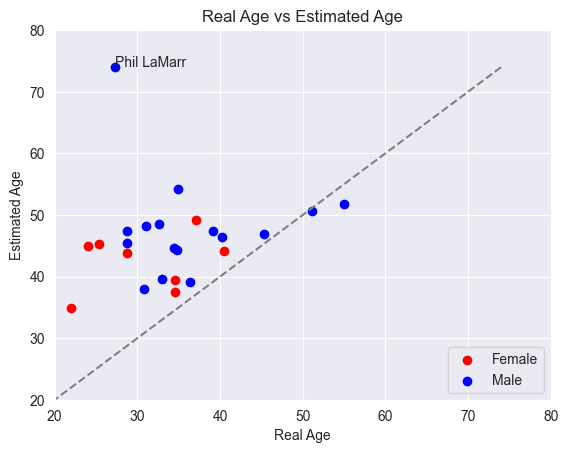

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming merged_df is your dataframe

# Separate the data for males and females
df_male = merged_df[merged_df['gender'] == 'M'].copy()
df_female = merged_df[merged_df['gender'] == 'F'].copy()

# Sort the dataframes
df_male.sort_values('screening_age', inplace=True)
df_female.sort_values('screening_age', inplace=True)

# Define outliers. Adjust this according to your definition of an "outlier"
outlier_threshold = df_male['vanpy_voxceleb_age_estimation'].quantile(0.95)

# Plot the data
plt.scatter(df_female['screening_age'], df_female['vanpy_voxceleb_age_estimation'], color='red', label='Female')
plt.scatter(df_male['screening_age'], df_male['vanpy_voxceleb_age_estimation'], color='blue', label='Male')

# Add labels to outliers
for i, row in df_male.iterrows():
    if row['vanpy_voxceleb_age_estimation'] > outlier_threshold:
        plt.text(row['screening_age'], row['vanpy_voxceleb_age_estimation'], row['actor'])

# Add a reference line
max_age = max(merged_df['screening_age'].max(), merged_df['vanpy_voxceleb_age_estimation'].max())
plt.plot([0, max_age], [0, max_age], color='gray', linestyle='--')

# Label the axes and title
plt.xlabel('Real Age')
plt.ylabel('Estimated Age')
plt.title('Real Age vs Estimated Age')

# Limit x and y ticks
plt.xlim(20, 80)
plt.ylim(20, 80)

# Show the legend
plt.legend()

# Show the plot
plt.show()

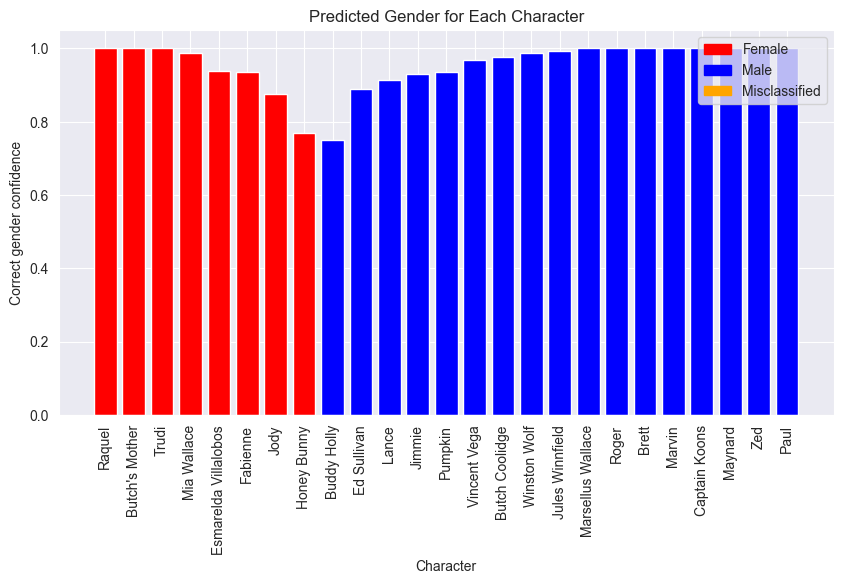

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Sort by gender_value
sorted_df = merged_df.sort_values('gender_value')

# Define a function to classify based on the threshold and real gender
def classify_gender(row):
    if row['gender_value'] >= 0.5 and row['gender'] == 'M':  # correctly classified as male
        return 'blue'
    elif row['gender_value'] < 0.5 and row['gender'] == 'F':  # correctly classified as female
        return 'red'
    else:  # misclassified
        return 'orange'

# Apply the function to create a list of colors
colors = sorted_df.apply(classify_gender, axis=1)

# Create the bar plot
plt.figure(figsize=(10, 5))  # Adjust size as needed
plt.bar(sorted_df['character'], sorted_df['gender_confidence'], color=colors)

# Label axes and title
plt.xlabel('Character')
plt.ylabel('Correct gender confidence')
plt.title('Predicted Gender for Each Character')

# Rotate x labels if needed
plt.xticks(rotation=90)

# Create legend
blue_patch = mpatches.Patch(color='blue', label='Male')
red_patch = mpatches.Patch(color='red', label='Female')
orange_patch = mpatches.Patch(color='orange', label='Misclassified')
plt.legend(handles=[red_patch, blue_patch, orange_patch])

# Show the plot
plt.show()

In [47]:
sorted_df['gender_confidence'].mean()

0.9541337026973014

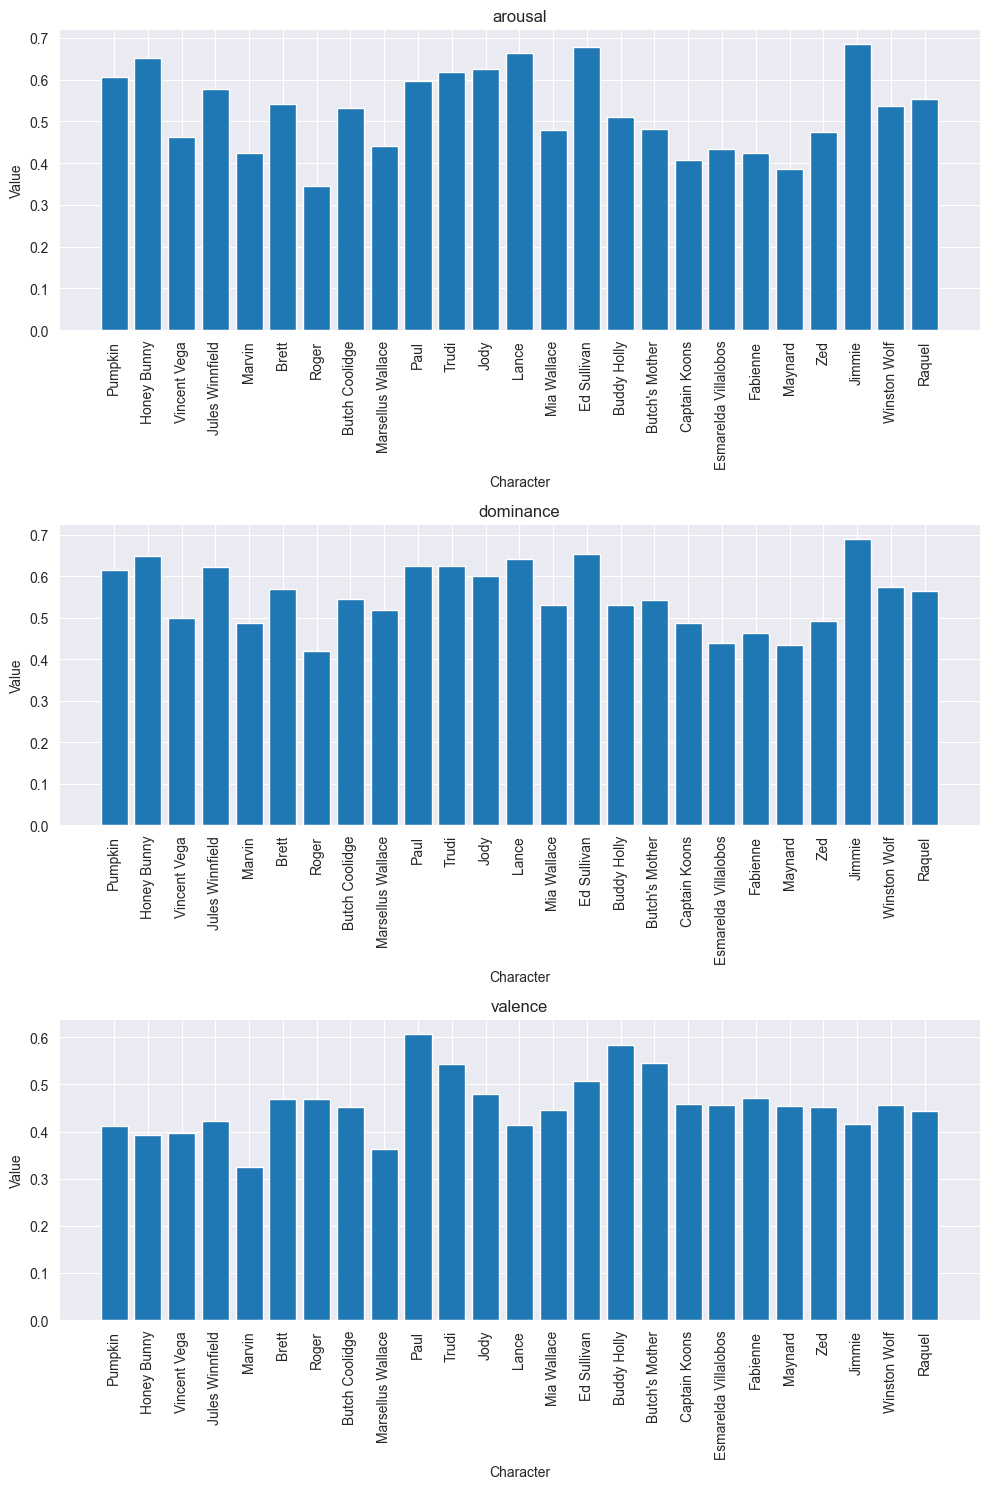

In [44]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots, one for each variable
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot each variable
for i, variable in enumerate(['arousal', 'dominance', 'valence']):
    ax[i].bar(merged_df['character'], merged_df[variable])
    ax[i].set_title(variable)
    ax[i].set_ylabel('Value')
    ax[i].set_xlabel('Character')
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=90)  # Rotate x labels if needed

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

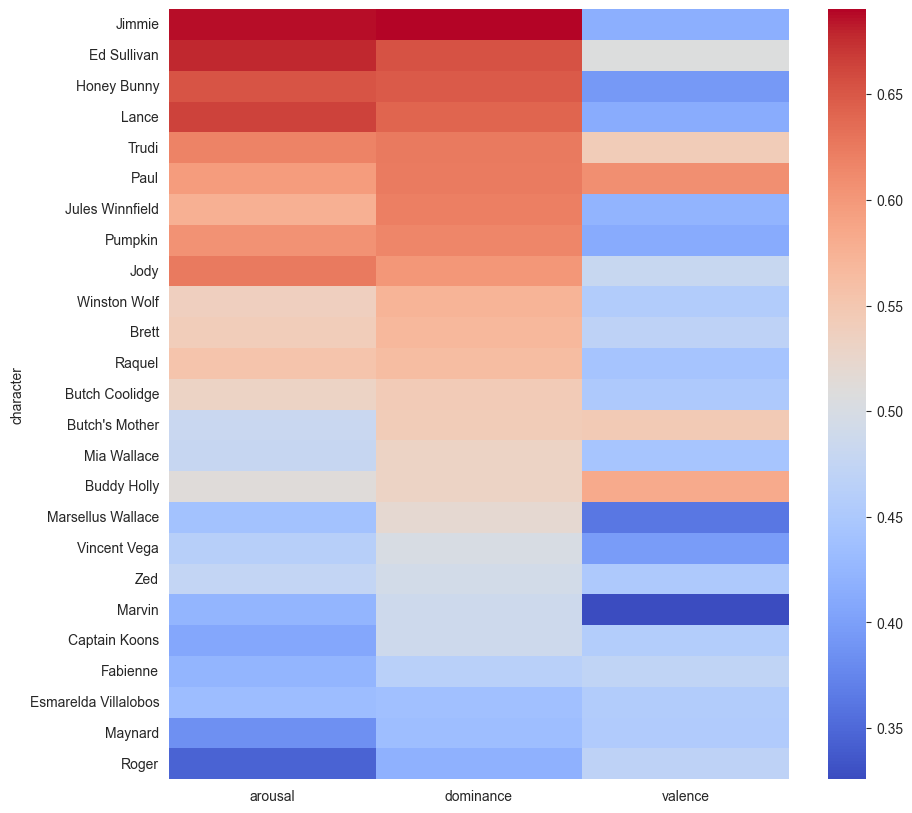

In [45]:
import seaborn as sns

# Sort in ascending order
sorted_df = merged_df.sort_values(by=['dominance', 'valence', 'arousal'], ascending=[False, False, False])
# Select relevant columns and set character as index
heatmap_data = sorted_df.set_index('character')[['arousal', 'dominance', 'valence']]

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='coolwarm')

plt.show()

In [27]:
# import seaborn as sns
#
# # Select relevant columns
# pairplot_data = sorted_df[['character', 'arousal', 'dominance', 'valence']]
#
# # Create the pairplot
# sns.pairplot(pairplot_data, hue='character')
#
# plt.show()

In [12]:
df.iloc[1000]

Unnamed: 0                                                 1000
speaker                                                   Lance
id                                                          811
duration                                                      2
text                          Have you lost your fucking mind ?
seg                               00:54:38,081 --> 00:54:40,415
start                                              00:54:38,081
end                                                00:54:40,415
start_tt                                               3278.081
end_tt                                                 3280.415
input_path    cut_preprocessed/audio_track_pulp_fiction_eng_...
Name: 1000, dtype: object